# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

This code has been (partly) made in collaboration with Jude Bethinger-Busquet during the lab session, any similarities in the code will be due to this collaboration


## <span style='color:deepskyblue'>Preliminaries</span>

In [1]:
# Install required packages
#%pip install getdist
#%pip install scipy
import scipy.integrate as integrate #integrate function
import numpy as np                  #allows use of trig functions, arrays, text to data, etc.
import matplotlib.pyplot as plt     #used to plot various graphs
import pandas as pd                 #convert data into dataframe
import getdist           #for reading the MCMC chain and generating the distribution
from getdist import plots, MCSamples

## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [2]:
pc = 3.086e16 # 1 parsec in m
omega_b = 0.05 #currently the only given value

# Hubble parameter [km s^-1 Mpc^-1], based on function provided above
def Hubble(z, h, omega_lambda, omega_CDM, omega_b): #hubble parameter in terms of omegas, z and h
    omega_m = omega_CDM + omega_b #matter in terms of cdm and baryon 
    omega_k = 1 - omega_m - omega_lambda 
    H0 = h * 100 #H0 [km s^-1 Mpc^-1] in terms of small h
    return H0 * np.sqrt(omega_lambda + omega_k * (1+z)**2 + omega_m * (1+z)**3) 

In order to test whether our Hubble parameter function is working, we need to define the parameters $\Omega_{\rm CDM}$, $\Omega_\Lambda$ and $h$, so we can plot the function. This is shown below:

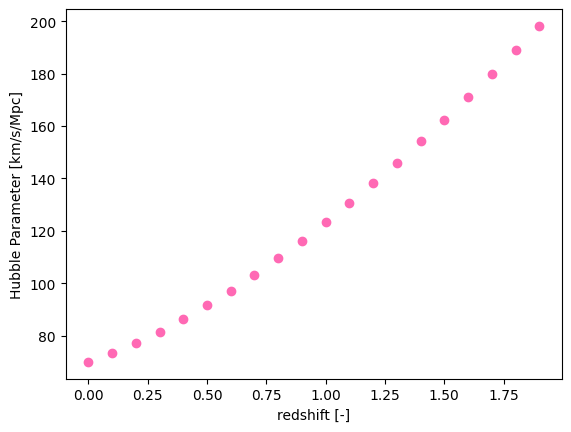

In [3]:
#we can use any values to test the function, so long as they're defined here:
omega_CDM = 0.25
omega_lambda = 0.7
h = 0.7

#make array of evenly spaced values that can be used as z-variable 
z_val = np.arange(0, 2, 0.1) #returns evenly spaced values in interval (0,2)
Hubble_val = [] #makes an empty list

for z in z_val:
    Hubble_val += [Hubble(z, h, omega_lambda, omega_b, omega_CDM)] #adds the result of Hubble function to the Hubble_Val list for each z in z_val

#now let's plot this result:
plt.scatter(z_val, Hubble_val, color = 'hotpink')
plt.xlabel('redshift [-]')
plt.ylabel('Hubble Parameter [km/s/Mpc]')
plt.show()

If both lists were the same size, it will have plotted somethign. However, are the plotted results realistic and accurate, i.e. did the Hubble parameter function actually work? If the function worked properly, we should see a $H({z})$ value of $70$ at $z=0$, as this is (roughly) the current value of the Hubble rate today ($z=0$). In order to quickly check whether the rest of the function worked properly, I made use of the Cosmological calculator for the Flat universe by Nick Gnedin of the University of Chicago. 

This calculator can be found here: https://astro.uchicago.edu/~gnedin/cc/ 

##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [4]:
c = 2.998e5 #value of speed of light in km/s (as H0 is in km/sMpc, c needs to be in km/s to cancel these units properly)

# Luminosity distance [Mpc] using formula provided above
def dL(z, Hubble, omega_b, omega_CDM, omega_lambda, h):
    omega_m = omega_CDM + omega_b #matter in terms of cdm and baryon 
    omega_k = 1 - omega_m - omega_lambda 
    H0 = h * 100 #H0 [km s^-1 Mpc^-1] in terms of small h
    def integrand(z):
        return H0 / Hubble(z, h, omega_lambda, omega_CDM, omega_b)
    Dz, _ = integrate.quad(integrand, 0, z)  
    if omega_k > 0: #all three different options for omega_k as shown above
        dL = c/H0 * (1+z) * 1/(np.sqrt(omega_k)) * np.sinh(np.sqrt(omega_k)*Dz)
    elif omega_k == 0: 
        dL = c/H0 * (1+z) * Dz
    else: 
        dL = c/H0 * (1+z) * 1/(np.sqrt(-omega_k)) * np.sin(np.sqrt(-omega_k)*Dz)
    return dL*10**6 #question asks for luminosity distance in parsecs, the default result is in Mpc due to H0 being in km/sMpc, so we multiply by 10^6

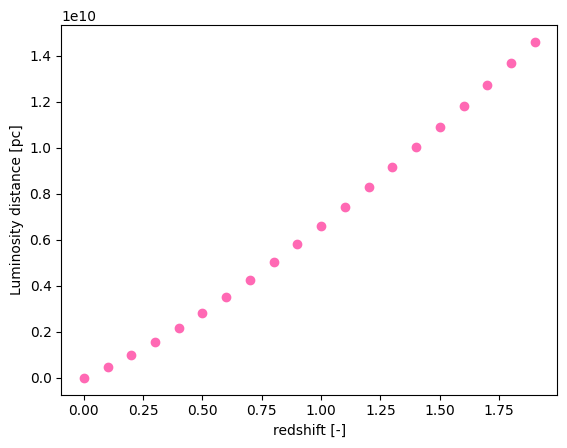

In [5]:
#once again, we can test whether this function works by defining the parameters
omega_CDM = 0.25
omega_lambda = 0.7
h = 0.7

dL_val = [] #an empty list 

for z in z_val: 
    dL_val += [dL(z, Hubble, omega_b, omega_CDM, omega_lambda, h)]  #adds the result of dL function to the dL_Val list for each z in z_val

#Now let's plot the z_val against distance_val to check the accuracy:
plt.scatter(z_val, dL_val, color = 'hotpink')
plt.xlabel('redshift [-]')
plt.ylabel('Luminosity distance [pc]')
plt.show()

To check the values, I once again made use of the Cosmological calculator for the Flat universe by Nick Gnedin of the University of Chicago:  https://astro.uchicago.edu/~gnedin/cc/ 


Let's also try to graph the distance modulus $\mu$:

C:\Users\laura\AppData\Local\Temp\ipykernel_33360\1794879247.py:3: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(dL/10)


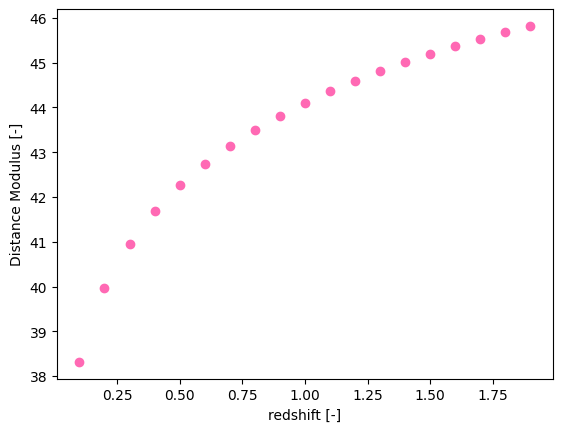

In [6]:
#returns a distance modulus value for a luminosity distance value
def mu(dL):
    return 5*np.log10(dL/10)

mu_val = [] #an empty list

for distance in dL_val:
    mu_val += [mu(distance)]   #adds the result of mu function to the mu_Val list for each distance in dL_val

#Let's plot distance modulus in terms of z as well:
plt.scatter(z_val, mu_val, color = 'hotpink')
plt.xlabel('redshift [-]')
plt.ylabel('Distance Modulus [-]')
plt.show()

## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [7]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

data = np.genfromtxt(dataloc)

print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [8]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus

In [9]:
# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

In order to visualize the data a little, I collected it in a dataframe. This is not a necessary step, but it was done to gain some additional insight into the data.

In [10]:
#Collecting all of the above in a dataframe and visualizing its characteristics:
SNIa_df = pd.DataFrame({"Redshift":zs,
                   "Distance Modulus":dist_mod,
                   "Distance Modulus Error":err_dist_mod,
                   "Luminosity Distance [pc]":dpc,
                   "Luminosity Distance [Mpc]":dMpc ,
                   "Error Luminosity Distance [Mpc]":dMe})

print(SNIa_df) #prints the dataframe
print(SNIa_df.describe()) #prints some key statistics of the dataframe


     Redshift  Distance Modulus  Distance Modulus Error  \
0    0.028488         35.346583                0.223906   
1    0.050043         36.682368                0.166829   
2    0.052926         36.817691                0.155756   
3    0.070086         37.446737                0.158467   
4    0.062668         37.483409                0.156099   
..        ...               ...                     ...   
575  1.017000         44.293971                0.171046   
576  1.315000         44.971358                0.187509   
577  0.821000         43.640939                0.194014   
578  1.215000         45.246521                0.560317   
579  0.623000         42.514524                0.241428   

     Luminosity Distance [pc]  Luminosity Distance [Mpc]  \
0                1.173050e+08                 117.305042   
1                2.170069e+08                 217.006920   
2                2.309608e+08                 230.960787   
3                3.085655e+08                 308.5

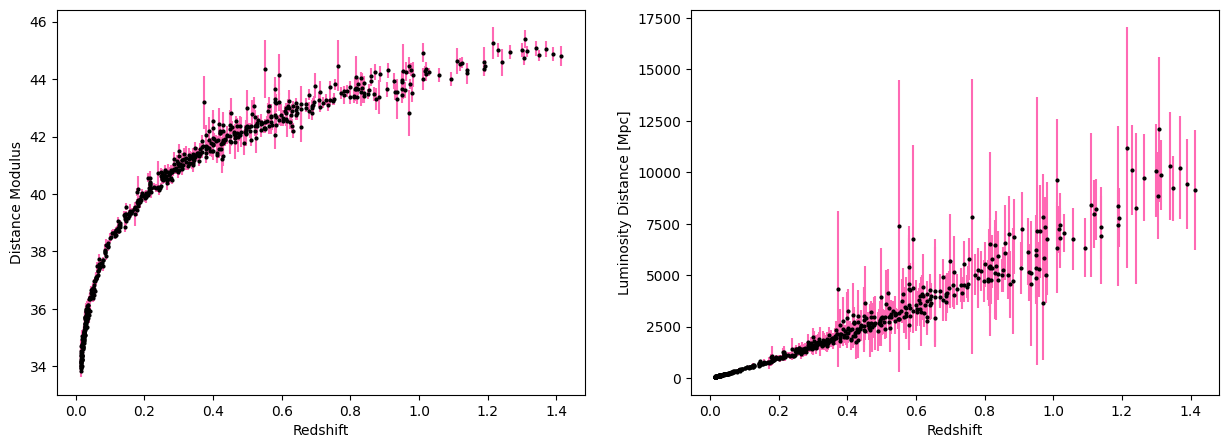

In [11]:
plt.subplots(1, 2, figsize=(15, 5)) #plots multiple plots next to each

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='.', color='black', ecolor='hotpink', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='.', color='black', ecolor='hotpink', markersize=4)
plt.show()

We can now check again whether the functions from part 1 are working properly by overlaying a fit of their graphs onto the plots shown above:

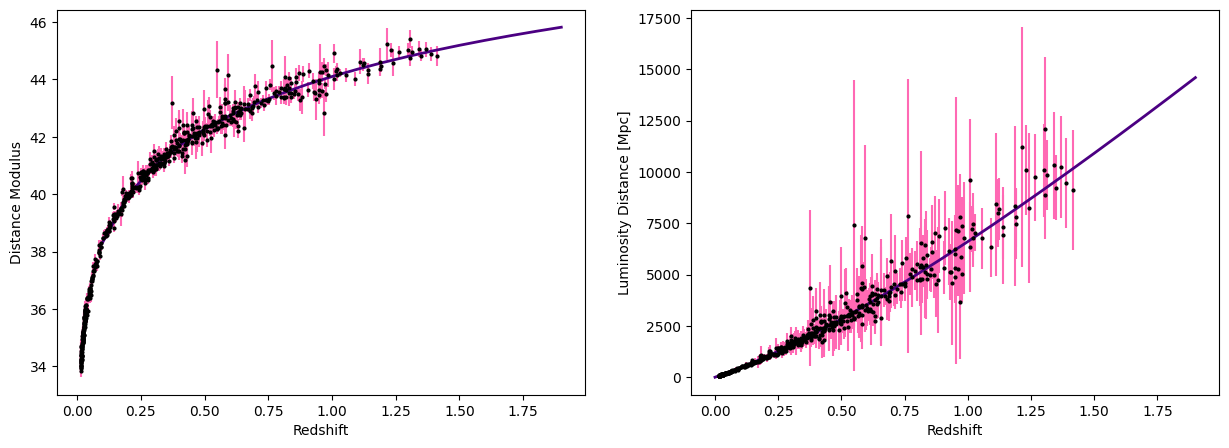

In [12]:
plt.subplots(1, 2, figsize=(15, 5))

#plot function output from part 1 over this data to see whether they line up
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='.', color='black', ecolor='hotpink', markersize=4)

plt.plot(z_val, mu_val, linewidth = 2, color='indigo') #plotting zu_val vs mu_val line over data above

plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='.', color='black', ecolor='hotpink', markersize=4)

dL_val = np.array(dL_val) #issues arose when trying to fit a line to dL_val vs. z_val as dl_val was a list and z_val an array, so dL_val is converted to an array

plt.plot(z_val, dL_val*10**-6, linewidth = 2, color='indigo')

plt.show()


## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [28]:
#Number of steps 
n_steps = 5000

# Define Chi-squared function
def chi_squared(h, omega_b, omega_CDM, omega_lambda, SNIa_df):
    # Compute theoretical distance modulus for all redshifts
    mu_pred = np.array([mu(dL(z, Hubble, omega_b, omega_CDM, omega_lambda, h)) for z in SNIa_df["Redshift"]])
    # Compute chi-squared from observed and theoretical mu
    chi2 = np.sum(((SNIa_df["Distance Modulus"] - mu_pred) / SNIa_df["Distance Modulus Error"]) ** 2)
    return chi2

def valid_parameters(omega_b, omega_CDM, omega_lambda, h): #this sets a starting range in which the new parameters need to be 
    return (0.04 < omega_b < 0.06 and 
            0 < omega_CDM < 1 and 
            0 < omega_lambda < 1 and 
            0.5 < h < 1.0)

#starting parameters, these dont need to be perfectly accurate, they will just form the starting point for the model to run
omega_b_old = 0.06
omega_CDM_old = 0.25
omega_lambda_old = 0.7
h_old = 0.7

#starting chi2, mcmc will compare new chi2 to old chi2 to determine whether the new parameters are more likely to be accurate
chi2_old = chi_squared(h_old, omega_b_old, omega_CDM_old, omega_lambda_old, SNIa_df)

accepted_parameters = [] #an empty list to record any new parameters accepted (i.e. better than the old parameters)

best_chi2 = chi2_old #a parameter in which to store the 'best' chi2 value
best_params = [omega_b_old, omega_CDM_old, omega_lambda_old, h_old] #a list of the 'best' parameters, gets completely replaced if there are better parameters found

for i in range(n_steps) : #will run 5000 times
    #randomly generates proposed parameters 
    omega_b_prop = omega_b_old + np.random.normal(0, 0.01) #np.random.normal generates a random number from a gaussian distribution (sigma 0.01) around 0
    omega_CDM_prop = omega_CDM_old + np.random.normal(0, 0.01)
    omega_lambda_prop = omega_lambda_old + np.random.normal(0, 0.01)
    h_prop = h_old + np.random.normal(0, 0.01)
    
    if valid_parameters(omega_b_prop, omega_CDM_prop, omega_lambda_prop, h_prop):
        chi2_prop = chi_squared(h_prop, omega_b_prop, omega_CDM_prop, omega_lambda_prop, SNIa_df) 
        r = np.random.rand() #draws a random number between 0 and 1
        accept_cond = np.exp((chi2_old - chi2_prop) / 2) #acceptance condition outlined 
        
        if r < accept_cond: #only accepts parameters if r < acceptance conditio
            chi2_old = chi2_prop #replaces the old values with the new accepted parameters for the next iteration
            omega_b_old = omega_b_prop
            omega_CDM_old = omega_CDM_prop
            omega_lambda_old = omega_lambda_prop
            h_old = h_prop 

            accepted_parameters.append([omega_b_old, omega_CDM_old, omega_lambda_old, h_old]) #records new parameters in list, doesnt overwrite

            if chi2_prop < best_chi2:
                best_chi2 = chi2_prop
                best_params = [omega_b_old, omega_CDM_old, omega_lambda_old, h_old] #record the best parameters, this will be overwritten any time the chi2 test yields a better result


print(accepted_parameters)  #prints the list of all parameters accepted throughout the steps
print(f"These are the best parameters found: {best_params}") #prints the best/most likely solution of parameters
    

[[0.04037774354970392, 0.2692129446678494, 0.6944239126237213, 0.6974884070429614], [0.040166621899486714, 0.275021619759247, 0.69373869479018, 0.6993963463371021], [0.047078398525391564, 0.2825400404884039, 0.7059991847683877, 0.6933351274375312], [0.044398182519621424, 0.27257551669303776, 0.7211487658388025, 0.6966693348674593], [0.04664675183511068, 0.2629735345392978, 0.713733855796288, 0.6967641592739413], [0.043752800454389035, 0.26926482433949783, 0.719540385404335, 0.7003444872353842], [0.04411529911274672, 0.28213357709166936, 0.7440080461881919, 0.6983836733755427], [0.05900225128510676, 0.27670222393275423, 0.7550687325849723, 0.7034401609185691], [0.04499659991270366, 0.25714510357852116, 0.7570266750016166, 0.6935787113685286], [0.05344402256647384, 0.27392397123405127, 0.7546563844199035, 0.7037061951910324], [0.05252553856610481, 0.2668542141717641, 0.7605517518414563, 0.7042886107808759], [0.0483052804358114, 0.24964678667026954, 0.7646390495711732, 0.6999116665064063]

After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

Removed no burn in
0.6989 < h < 0.7064 at 68% CL
0.2866 < omega_m < 0.3794 at 68% CL
0.7513 < omega_lambda < 0.8911 at 68% CL
-0.2489 < omega_k < -0.0473 at 68% CL


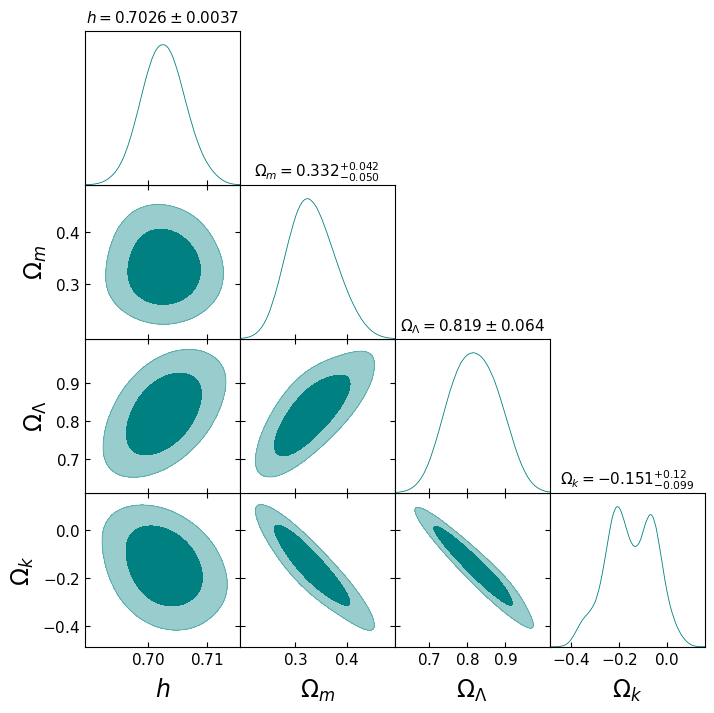

In [36]:
samples = np.array(accepted_parameters) #takes accepted_parameters and turns it into an array

#our array still contains omega_b and omega_cdm, but we would like it to instead turn out omega_m and omega_k:
omega_m_list = accepted_parameters[:, 0] + accepted_parameters[:, 1]  # Omega_m = Omega_b + Omega_CDM
omega_k_list = 1 - (omega_m_list + accepted_parameters[:, 2])  # Omega_k = 1 - (Omega_m + Omega_Lambda)

samples = np.transpose(np.array([accepted_parameters[:, 3], omega_m_list, accepted_parameters[:, 2], omega_k_list]))

labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']  #makes a list of the label names
names = ['h', 'omega_m', 'omega_lambda', 'omega_k'] #a list of the names
dim = len(names)  #number of names in the above list (4)

#reshape to mcsamples so .confidence can be used 
mc_samples = MCSamples(samples=samples, labels=labels, names=names)

#set the confidence level for the posterior analysis. This value corresponds to 68.27%, which is commonly used for 1-sigma confidence intervals.
conf_level = 0.6827

#print confidence intervals for the 1D posteriors
for name in names:
    lower_bound = round(mc_samples.confidence(name, (1. - conf_level) / 2., upper=False), 4) #calculate the lower bound of the confidence interval for the parameter.
    upper_bound = round(mc_samples.confidence(name, (1. - conf_level) / 2., upper=True), 4) #calculate the upper bound of the confidence interval for the parameter.
    print(f"{lower_bound} < {name} < {upper_bound} at {int(100 * conf_level)}% CL") #print the confidence interval for the parameter at the specified confidence level.
#the confidence intervals code was sourced from Karsten Dekkers, github: Karsten2703, who took PRA3024 in 2024 and gracefully allowed me to have a look at his code

#create the triangle corner plot with 1D posteriors
j = plots.getSubplotPlotter(subplot_size=2)
j.settings.axes_labelsize = 20
j.settings.axes_fontsize = 14
j.settings.solid_colors = ['teal']  #fill color for plots
j.triangle_plot(mc_samples, filled=True, title_limit=1)
    
# Show the plot
plt.show()

The results shown above are somewhat accurate to our physical universe. $\Omega_\Lambda$ in particular is relatively high, as although sources disagree slightly, the accepted values are generally around 0.67 (T. M. C. Abbott et al, 2019 (ApJL 872 L30 DOI: 10.3847/2041-8213/ab04fa)). This then results in an $\Omega_k$ value that is too low, as it should be closer to 0. However, both $\Omega_m$ and $h$ are relatively accurate, with the former being predicted to be 0.332 in a flat $\Lambda CDM$ model by Abbott et al in 2019. The reason for these discrepancies could be due to could be due to a combination of factors, including limitations in the observational data, systematic errors, and constraints in the MCMC sampling process. One potential issue is the accuracy of the Type Ia supernova data used, as systematic biases in redshift measurements or distance modulus uncertainties could lead to an overestimation of parameters. 
​

Additionally, the prior constraints in the cosmological parameters may not be restrictive enough, allowing the MCMC algorithm to explore parameter spaces that do not align with established cosmological models, resulting in the algorithm 'getting stuck' in a local minimum instead. Another contributing factor could be the step size of the MCMC algorithm. If the step size is too large, the algorithm may struggle to efficiently explore the parameter space, leading to an uneven sampling of values. If the step size is too small, the MCMC chain may not converge efficiently, resulting in an incomplete sampling of the posterior distribution. After consideration, a step size of 0.01 resulted in the most consistent results, which is why the choice was made to keep this step size regardless of the inaccuracy of some of the values found.